### **FINAL PROJECT** - Build a neural network to predict if a patient has pneumonia or not based on X-ray chest

By:

*   Carlos Pérez
*   Sergio González
*   Marcos Uceta


### **1) Import everything that we need**

We will do this using Analytic Zoo with Orca.

In [1]:
# Install jdk8
!apt-get install openjdk-8-jre-headless -qq > /dev/null

import os

# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [2]:
# Install latest pre-release version of Analytics Zoo
%%capture
!pip install --pre --upgrade analytics-zoo[ray]

In [3]:
# Our data is storaged in .zip format
import zipfile

# Orca functions
from bigdl.dataset import base
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from pathlib import Path

# Needed to transform and plot our data
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from zoo.orca.learn.tf2 import Estimator

In [4]:
# For image pre-processing
%%capture
!pip install sparkdl

### **2) Load the data**

We will use a database from Kaggle. First, we will install it and then download the specific database.

In [5]:
%%capture

# Install kaggle
!pip install kaggle

# Making a directory named “.kaggle”
! mkdir ~/.kaggle

# Copying the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

# Allocating the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

# Downloading the desired dataset:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzipping the data:
! unzip chest-xray-pneumonia.zip

### **3) Data preprocessing**

To ensure a reliable model, we need to give it reliable data to build it. In this case, we need to pre-processed the images to remove those that can be unreliable.

Filtering out corrupted images in train set:

In [6]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/chest_xray/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 173 images


Filtering out corrupted images in validation set:

In [7]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/chest_xray//val", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 6 images


Filtering out corrupted images in test set:

In [8]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/chest_xray/test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 38 images


### **4) Visualize the data**

To do that, first we need to configure some parameters to be able to store and see it.

In [9]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_data('/content/chest_xray/train')
test = get_data('/content/chest_xray/test')
val = get_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


When we are working with this type of data, that we will use to create machine learning models, it is vital to know with what we are working. Let's see how many images are of normal cases and how much are of pneumonia cases.

In training:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


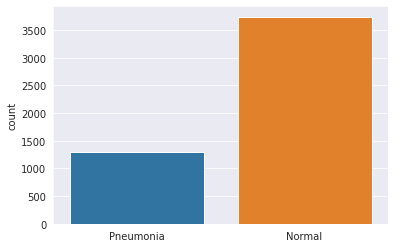

In [11]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

In validation:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


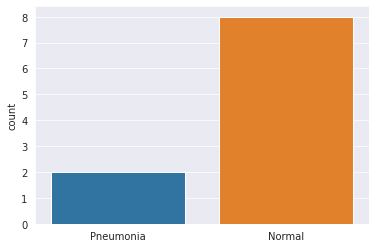

In [12]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

In test:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


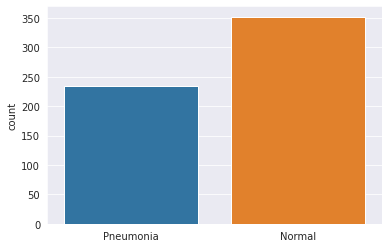

In [13]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

We have a larger number of normal samples than pneumonia samples in training set; while it is quite good distributed in validation and test set. This is important because the better distributed is our data, the better is trained our model.

Let's see how looks the normal samples and the pneumonia samples:

Text(0.5, 1.0, 'PNEUMONIA')

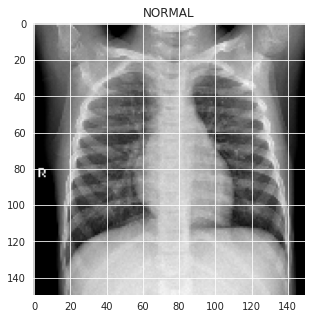

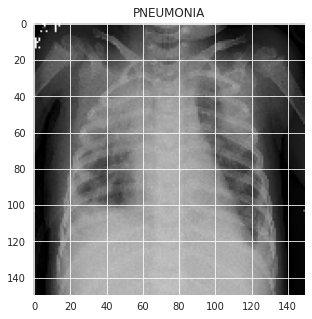

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### **4) Load the data and create the train, validation and test sets**

We need to convert it from a directory to a set of images to give it to our model.

In [15]:
data_dir = "/content/chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [16]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

We also have to create the functions to import our training, validation and test set and process them.

In [17]:
target_size= (28,28)

In [18]:
def preprocess(x, y):
    x = tf.cast(tf.reshape(x, (28, 28, 3)), dtype=tf.float32) / 255.0
    return x, y

In [19]:
def train_creator(config, batch_size):
    data = image_dataset_from_directory(train_dir, 
                                            image_size=target_size, 
                                            batch_size = 1,
                                            shuffle=True,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])
    
    data = data.repeat().map(preprocess).shuffle(1000).batch(batch_size)
    return data

In [20]:
def val_creator(config, batch_size):
    data = image_dataset_from_directory(val_dir, 
                                            image_size=target_size, 
                                            batch_size = 1,
                                            shuffle=True,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])

    data = data.repeat().map(preprocess).shuffle(1000).batch(batch_size)
    return data

In [21]:
def test_creator(config, batch_size):
    data = image_dataset_from_directory(test_dir, 
                                            image_size=target_size, 
                                            batch_size = 1,
                                            shuffle=False,
                                            color_mode='rgb',
                                            label_mode='binary',
                                            class_names = ['NORMAL', 'PNEUMONIA'])
    
    data = data.repeat().map(preprocess).batch(batch_size)
    return data

### **5) Build the Convolutional Neural Network**

Our neural network is based on keras, that it is available to run in an Orca context.

In [22]:
def model_creator(config):
    import tensorflow as tf
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(20, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                                input_shape=(28, 28, 3), padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(50, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(500, activation='tanh'),
         tf.keras.layers.Dense(2, activation='softmax'),
         ]
    )

    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
lr_reduction = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=2, verbose=0.0001,
                                                restore_best_weights=True)

### **6) Train our model** 

To run in an Orca context, we need to activate it.

In [24]:
%%capture
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).
init_orca_context(cluster_mode="local", cores=2, memory= "8g") # run in local mode

Create our Orca estimator.

In [25]:
%%capture
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=2)

And train it.

In [26]:
batch_size = 320
est.fit(train_creator, epochs=4, batch_size= batch_size,
                steps_per_epoch= 320,
                validation_data=val_creator,
                validation_steps= 320,
                callbacks= lr_reduction)

(pid=521) Found 5043 files belonging to 2 classes.
(pid=522) Found 5043 files belonging to 2 classes.


(pid=522) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fbcd61b5e60> and will run it as-is.
(pid=522) Cause: Unable to locate the source code of <function preprocess at 0x7fbcd61b5e60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
(pid=522) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=521) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fe1b5cc2e60> and will run it as-is.
(pid=521) Cause: Unable to locate the source code of <function preprocess at 0x7fe1b5cc2e60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If

(pid=522) Found 10 files belonging to 2 classes.
(pid=521) Found 10 files belonging to 2 classes.


(pid=522) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fbca3076200> and will run it as-is.
(pid=522) Cause: Unable to locate the source code of <function preprocess at 0x7fbca3076200>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
(pid=522) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=521) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fe182b8c3b0> and will run it as-is.
(pid=521) Cause: Unable to locate the source code of <function preprocess at 0x7fe182b8c3b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If

(pid=521) Epoch 1/4
320/320 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.9076


(pid=522) 2022-02-18 11:11:53.559050: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
(pid=522) op: "TensorSliceDataset"
(pid=522) input: "Placeholder/_0"
(pid=522) attr {
(pid=522)   key: "Toutput_types"
(pid=522)   value {
(pid=522)     list {
(pid=522)       type: DT_STRING
(pid=522)     }
(pid=522)   }
(pid=522) }
(pid=522) attr {
(pid=522)   key: "_cardinality"
(pid=522)   value {
(pid=522)     i: 10
(pid=522)   }
(pid=522) }
(pid=522) attr {
(pid=522)   key: "is_files"
(pid=522)   value {
(pid=522)     b: false
(pid=522)   }
(pid=522) }
(pid=522) attr {
(pid=522)   key: "metadata"
(pid=522)   value {
(pid=522)     s: "\n\025TensorSliceDataset:12"
(pid=522)   }
(pid=522) }
(pid=522) attr {
(pid=522)   key: "output_shapes"
(pid=522)   value {
(pid=522)     list {
(pid=522)   

320/320 [==============================] - 1956s 6s/step - loss: 0.2670 - accuracy: 0.9076 - val_loss: 0.0516 - val_accuracy: 1.0000
(pid=521) Epoch 2/4
320/320 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9800


(pid=521) 2022-02-18 11:43:54.076197: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(pid=522) 2022-02-18 11:43:54.129674: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 [==============================] - 1902s 6s/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 0.0104 - val_accuracy: 1.0000
(pid=521) Epoch 3/4
320/320 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9923


(pid=522) 2022-02-18 12:16:04.750490: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(pid=521) 2022-02-18 12:16:04.819609: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 [==============================] - 1907s 6s/step - loss: 0.0367 - accuracy: 0.9923 - val_loss: 0.0036 - val_accuracy: 1.0000
(pid=521) Epoch 4/4
320/320 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9957


(pid=521) 2022-02-18 12:48:06.943983: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(pid=522) 2022-02-18 12:48:06.978497: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


320/320 [==============================] - 1890s 6s/step - loss: 0.0228 - accuracy: 0.9957 - val_loss: 2.9591e-04 - val_accuracy: 1.0000


{'train_accuracy': 0.9956836104393005,
 'train_loss': 0.022799834609031677,
 'train_val_accuracy': 1.0,
 'train_val_loss': 0.0002959087723866105}

### **7) Evaluate our model** 

Last step, how good is our model? Let's evaluate it.

In [27]:
est.evaluate(test_creator, num_steps= 320)

(pid=521) Found 586 files belonging to 2 classes.
(pid=522) Found 586 files belonging to 2 classes.


(pid=521) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fe182bd93b0> and will run it as-is.
(pid=521) Cause: Unable to locate the source code of <function preprocess at 0x7fe182bd93b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
(pid=521) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=522) WARNING:tensorflow:AutoGraph could not transform <function preprocess at 0x7fbca30768c0> and will run it as-is.
(pid=522) Cause: Unable to locate the source code of <function preprocess at 0x7fbca30768c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If

320/320 [==============================] - 90s 277ms/step - loss: 2.8806 - accuracy: 0.7262


{'validation_accuracy': 0.7261718511581421,
 'validation_loss': 2.8806023597717285}

Our model doesn't have a great accuracy to predict the test set, even that showed a great level of accuracy with the training and validation set. Still, it needs to be improved.

Finally, we stop the orca context.

In [28]:
stop_orca_context()

Stopping orca context


### **8) Recap**

In this paper, we have created a neural network model to predict whether a person has pneumonia or not based on chest X-ray images. First, we loaded the data and preprocessed it to obtain high quality images that allow our model to correctly differentiate the images. Next, we created our training, validation and test set by introducing some parameters to improve the accuracy of our model (suffraying and flipping the samples, as well as resizing and rescaling them). Then, we built our keras model and ran it in an Orca context environment and tested it.

As mentioned before, it needs to be improved to be ready for use in clinical stages yet.